# Descan + STEM Overfocus procedure

Suppose we want to calibriate and verify the experimental microscope parameters of a fourdstem dataset which suffers from descan error - 

This notebook shows that using three vacuum reference datasets, taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings), one can characterise first the descan error, and semi-convergence angle of the beam. 

Then using a back reconstruction step with the known descan error and semi-convergence values, and the 4D stem experimental dataset, we can determine the scan step, scan rotation, detector flip and defocus values of the microscope system. 

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from scipy.optimize import curve_fit
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF, RegressionOptions
from libertem.udf.masks import ApplyMasksUDF
from skimage.measure import label, regionprops

In [2]:
import microscope_calibration.components as comp
from interactive import interactive_window

Here load three vacuum reference datasets calculated with three known camera_lengths. 

In [3]:
ctx = lt.Context.make_with("inline")  # no parallelisation, good for debugging
datasets = {
    0.5: ctx.load("npy", "./fourdstem_array_0.5.npy"),
    1.0: ctx.load("npy", "./fourdstem_array_1.0.npy"),
    1.5: ctx.load("npy", "./fourdstem_array_1.5.npy"),
}

Just for visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

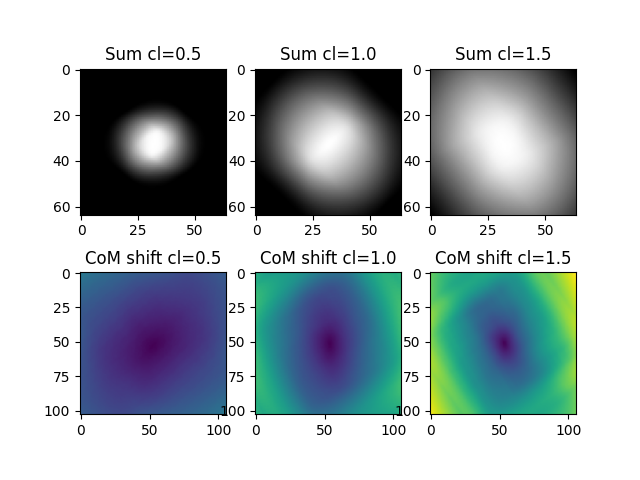

In [4]:
fig, axs = plt.subplots(2, 3)

px_shifts_matrix = {
    0.5: None,
    1.0: None,
    1.5: None,
}

shifts = {
    0.5: None,
    1.0: None,
    1.5: None,
}

distances = {
    0.5: None,
    1.0: None,
    1.5: None,
}

com_r = {}
com_udf = CoMUDF.with_params(regression=RegressionOptions.SUBTRACT_LINEAR)
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
    px_shifts_matrix[cl] = com_res["regression"].data
    shifts[cl] = com_res["raw_shifts"].data
    distances[cl] = np.hypot(shifts[cl][..., 0], shifts[cl][..., 1])

vmax = max(np.max(shift) for shift in distances.values())
for i, (cl, ds) in enumerate(datasets.items()):
    distance = distances[cl]
    axs[1, i].imshow(distance, vmin=0, vmax=vmax)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is mose descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

Now we have an estimate of the CoM shift for each dataset we can compute a point virtual detector image with the most basic kind of error compensation: Simply fitting a 3x3 affine transform matrix to the pixel shifts, and using that to registrate each disk back to the centre of the detector. The drawback is we must compute a new affine transform for each camera length, and we do not correct for astigmatism in the disks.

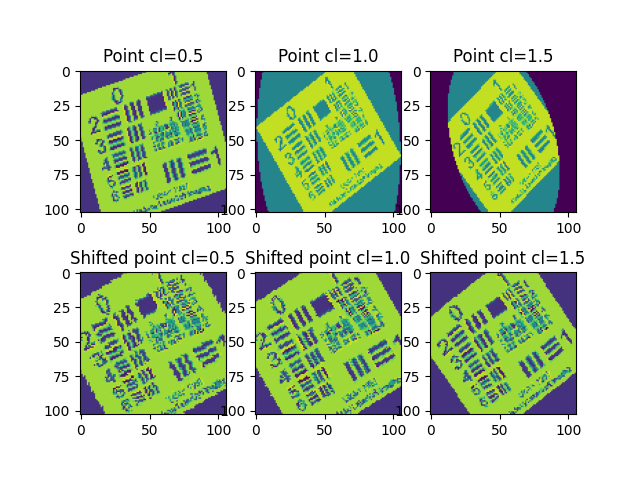

In [5]:
sy, sx = ds.shape.sig.to_tuple()
mask_px = sy // 2, sx // 2


def mask_factory():
    mask = np.zeros((sy, sx), dtype=np.float32)
    mask[mask_px] = 1.0
    return mask


masks_udf = ApplyMasksUDF(
    [mask_factory],
    use_torch=False,
    use_sparse=False,
    mask_count=1,
)

fig, axs = plt.subplots(2, 3)

for i, (cl, ds) in enumerate(datasets.items()):
    masks_shifted_udf = ApplyMasksUDF(
        [mask_factory],
        use_torch=False,
        use_sparse=False,
        mask_count=1,
        shifts=ApplyMasksUDF.aux_data(
            np.round(com_r[cl]["raw_shifts"].data).astype(int),
            dtype=int,
            kind="nav",
            extra_shape=(2,),
        ),
    )

    sum_res, com_res = ctx.run_udf(ds, [masks_udf, masks_shifted_udf])

    axs[0, i].imshow(sum_res["intensity"].data)
    axs[0, i].set_title(f"Point cl={cl}")
    axs[1, i].imshow(com_res["intensity"].data)
    axs[1, i].set_title(f"Shifted point cl={cl}")

As we can see, the descan compensation approximately corrects for the distortion of the scan grid, making the point image square, and independent of camera length.

We can now determine scan rotation, step and flip on one dataset, while ignoring the descan error

In [6]:
cl = 1.0
ds = datasets[cl]
det_px_size = (0.004, 0.004)  # YX!
pxshifts = px_shifts_matrix[cl]

nav_shape = ds.shape.nav
rand_nav_x, rand_nav_y = (
    np.random.randint(0, nav_shape[0]),
    np.random.randint(0, nav_shape[1]),
)

pick_a = ctx.create_pick_analysis(ds, rand_nav_x, rand_nav_y)
frame = ctx.run(pick_a).intensity.raw_data
shift = shifts[1.0][rand_nav_y, rand_nav_x]
frame = np.roll(frame, -1 * shift, axis=(0, 1))
radius = (
    max(
        regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
    ).equivalent_diameter
    / 2
)
semi_conv_guess = (radius * det_px_size[0]) / cl

# initial_guesses
model_parameters = {
    "semi_conv": float(semi_conv_guess),
    "defocus": 0.02,  # Distance from the crossover to the sample
    "camera_length": cl,  # Distance from the sample to the detector
    "scan_shape": ds.shape.nav,  # YX!
    "det_shape": ds.shape.sig,  # YX!
    "scan_step": (0.0001, 0.0001),  # YX!
    "det_px_size": det_px_size,  # YX!
    "scan_rotation": 30.0,
    "descan_error": np.zeros((8,)),
    "flip_y": False,
    "px_shifts": pxshifts,  # YX!
}
interactive_window(ctx, ds, model_parameters)

ValueError: invalid entry in coordinates array

We would have to determine the defocus of each dataset separately, unless we knew it was unchanged

In [ ]:
flip_y = False
semiconv = 0.1
scan_rotation = 30
defocus = 0.02
scan_step = (0.0001, 0.0001)
det_px_size = (0.004, 0.004)
flip_y = False

With these parameters determined and more certainty on the input coordinate scan coordinates, we can then solve simultaneously on the three datasets to determine the descan error matrix that describes the microscope experiment. This descan error matrix will determine the propagation matrix of the microscope that describes the descan error dependance on camera length, and enable us to correct for astigmatism in the disks also.

In [ ]:
scan_coords = []
det_coords = []
b_vals = []
for camera_length, ds in datasets.items():
    crossover_z = jnp.zeros((1))
    ScanGrid = comp.ScanGrid(
        z=jnp.array([defocus]),
        scan_step=scan_step,
        scan_shape=ds.shape.nav.to_tuple(),
        scan_rotation=scan_rotation,
    )
    scan_coords.append(ScanGrid.coords)
    Detector = comp.Detector(
        z=jnp.array(camera_length),
        det_shape=ds.shape.sig.to_tuple(),
        det_pixel_size=det_px_size,
        flip_y=flip_y,
    )
    yx_px_det = com_r[camera_length]["raw_com"].data.reshape(-1, 2)
    det_coords.append(np.stack(Detector.pixels_to_metres(yx_px_det.T), axis=1))
    b_vals.append(camera_length - defocus)

bvals = np.concatenate(
    tuple(np.full((c.shape[0],), b) for b, c in zip(b_vals, scan_coords))
)
scan_coords = np.concatenate(scan_coords, axis=0)
det_coords = np.concatenate(det_coords, axis=0)
bvals.shape

(32754,)

In [ ]:
def descan_model(vars, Adx_dpos, Cdx_dslope, Ady_dpos, Cdy_dslope):
    xin, yin, B = vars
    return xin * (Adx_dpos + B * Cdx_dslope) + yin * (Ady_dpos + B * Cdy_dslope)


# Take only N random samples from the data
num_samples = 10000
indices = np.random.choice(bvals.size, num_samples, replace=False)

popt_x, pcov_x = curve_fit(
    descan_model,
    (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]),
    det_coords[:, 0][indices],
    p0=np.zeros(4),
)
Axx, Cxx, Axy, Cxy = popt_x

popt_y, pcov_y = curve_fit(
    descan_model,
    (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]),
    det_coords[:, 1][indices],
    p0=np.zeros(4),
)
Ayx, Cyx, Ayy, Cyy = popt_y

In [ ]:
print("\nFit ABCD Values (with 5-sigma error):")
print(f"Axx_dpos = {Axx:.2f} ± {5 * np.sqrt(pcov_x[0, 0]):.2e}")
print(f"Axy_dpos = {Axy:.2f} ± {5 * np.sqrt(pcov_x[2, 2]):.2e}")
print(f"Ayx_dpos = {Ayx:.2f} ± {5 * np.sqrt(pcov_y[0, 0]):.2e}")
print(f"Ayy_dpos = {Ayy:.2f} ± {5 * np.sqrt(pcov_y[2, 2]):.2e}")
print(f"Cxx_dslope = {Cxx:.2f} ± {5 * np.sqrt(pcov_x[1, 1]):.2e}")
print(f"Cxy_dslope = {Cxy:.2f} ± {5 * np.sqrt(pcov_x[3, 3]):.2e}")
print(f"Cyx_dslope = {Cyx:.2f} ± {5 * np.sqrt(pcov_y[1, 1]):.2e}")
print(f"Cyy_dslope = {Cyy:.2f} ± {5 * np.sqrt(pcov_y[3, 3]):.2e}")

Axx, Ayy, Cxx, Cyy = (
    8,
    6,
    -20,
    -16,
)  # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
Axy, Ayx, Cxy, Cyx = (
    12,
    -14,
    -12,
    20,
)  # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix


Fit ABCD Values (with 5-sigma error):
Axx_dpos = 7.03 ± 1.34e-01
Axy_dpos = 11.28 ± 1.36e-01
Ayx_dpos = -13.25 ± 1.73e-01
Ayy_dpos = 4.65 ± 1.77e-01
Cxx_dslope = -19.34 ± 1.27e-01
Cxy_dslope = -11.19 ± 1.29e-01
Cyx_dslope = 19.05 ± 1.64e-01
Cyy_dslope = -14.87 ± 1.67e-01


In [ ]:
cl = 1.0
ds = datasets[cl]
# initial_guesses
model_parameters = {
    "semi_conv": semiconv,
    "defocus": defocus,  # Distance from the crossover to the sample
    "camera_length": cl,  # Distance from the sample to the detector
    "scan_shape": ds.shape.nav,  # YX!
    "det_shape": ds.shape.sig,  # YX!
    "scan_step": scan_step,  # YX!
    "det_px_size": det_px_size,  # YX!
    "scan_rotation": scan_rotation,
    "descan_error": np.asarray([Axx - 1, Axy, Ayx, Ayy - 1, Cxx, Cxy, Cyx, Cyy]),
    "flip_y": flip_y,
    "px_shifts": None,  # YX!
}
interactive_window(ctx, ds, model_parameters)

BokehModel(combine_events=True, render_bundle={'docs_json': {'651826d1-7104-4f27-8138-006dbc0fd873': {'version…